In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import scipy as sp
import seaborn as sns
import re
import csv
from scipy import stats, integrate
%matplotlib inline

from sklearn import ensemble
from sklearn.metrics import classification_report
from sklearn.model_selection import cross_val_score
from sklearn.metrics import confusion_matrix
from sklearn.svm import SVC

"Human Activity Recognition (HAR) is a research field that aims to identify the actions carried out by one or more subjects through the gathering and understanding of context information about the user state and its surrounding environment."[1] The ability of machine to sense, filter, interpret, and possibly mimic human activity and behavior is a widely applicable research field to many industries including healthcare, construction, and teaching. 

Today I will be presenting my analysis and model of a 2013 dataset where 30 participates from ages 19 to 48 used a waist-mounted smartphone as they performed a set of 6 motion sequences: standing, sitting, laying, walking, walking upstairs and walking downstairs. While various home environment or on-body sensors are available to monitor many type of activities, smart phones are becoming increasingly common around the world and are incorporating more inertial sensors such as accelerometers, gyroscopes and magnetometers. This makes smart phones an ideal tool to reach a large section of the population and is not as restricted by location or battery life.  

https://www.kaggle.com/uciml/human-activity-recognition-with-smartphones
http://www.jucs.org/jucs_19_9/energy_efficient_smartphone_based/jucs_19_09_1295_1314_anguita.pdf
https://archive.ics.uci.edu/ml/datasets/Smartphone-Based+Recognition+of+Human+Activities+and+Postural+Transitions#
https://www.youtube.com/watch?v=XOEN9W05_4A
https://www.icephd.org/sites/default/files/IWAAL2012.pdf
https://www.elen.ucl.ac.be/Proceedings/esann/esannpdf/es2013-11.pdf

Research Questions:

- Can the activity of a individual be accurately predicted from a smart phone's internal sensors?
- What variables are most important for a model to predict activity with a smart phone?
- Which model most accurately predicts activity with a smart phone?

### Step One

Go out and find a dataset of interest. It could be from one of our recommended resources, some other aggregation, or scraped yourself. Just make sure it has lots of variables in it, including an outcome of interest to you.

In [2]:
train_data = pd.read_csv('Smart_train.csv.zip')
test_data = pd.read_csv('Smart_test.csv.zip')

In [3]:
train_data.head()

,tBodyAcc-mean()-X,tBodyAcc-mean()-Y,tBodyAcc-mean()-Z,tBodyAcc-std()-X,tBodyAcc-std()-Y,tBodyAcc-std()-Z,tBodyAcc-mad()-X,tBodyAcc-mad()-Y,tBodyAcc-mad()-Z,tBodyAcc-max()-X,...,fBodyBodyGyroJerkMag-kurtosis(),"angle(tBodyAccMean,gravity)","angle(tBodyAccJerkMean),gravityMean)","angle(tBodyGyroMean,gravityMean)","angle(tBodyGyroJerkMean,gravityMean)","angle(X,gravityMean)","angle(Y,gravityMean)","angle(Z,gravityMean)",subject,Activity
0,0.288585,-0.020294,-0.132905,-0.995279,-0.983111,-0.913526,-0.995112,-0.983185,-0.923527,-0.934724,...,-0.710304,-0.112754,0.030400,-0.464761,-0.018446,-0.841247,0.179941,-0.058627,1,STANDING
1,0.278419,-0.016411,-0.123520,-0.998245,-0.975300,-0.960322,-0.998807,-0.974914,-0.957686,-0.943068,...,-0.861499,0.053477,-0.007435,-0.732626,0.703511,-0.844788,0.180289,-0.054317,1,STANDING
2,0.279653,-0.019467,-0.113462,-0.995380,-0.967187,-0.978944,-0.996520,-0.963668,-0.977469,-0.938692,...,-0.760104,-0.118559,0.177899,0.100699,0.808529,-0.848933,0.180637,-0.049118,1,STANDING
3,0.279174,-0.026201,-0.123283,-0.996091,-0.983403,-0.990675,-0.997099,-0.982750,-0.989302,-0.938692,...,-0.482845,-0.036788,-0.012892,0.640011,-0.485366,-0.848649,0.181935,-0.047663,1,STANDING
4,0.276629,-0.016570,-0.115362,-0.998139,-0.980817,-0.990482,-0.998321,-0.979672,-0.990441,-0.942469,...,-0.699205,0.123320,0.122542,0.693578,-0.615971,-0.847865,0.185151,-0.043892,1,STANDING


### Step Two

Explore the data. Get to know the data. Spend a lot of time going over its quirks and peccadilloes. You should understand how it was gathered, what's in it, and what the variables look like.

In [4]:
print(train_data.shape)
print(test_data.shape)

(7352, 563)
(2947, 563)


Now this dataset has a very large number of features. To begin explaining them I will need to go into how this data was recorded and analyze. The features used in this database come from the accelerometer and gyroscope 3-axial raw signals.  The 'XYZ' is used to denote 3-axial signals in the X, Y and Z directions. The prefix 't' refers to time and it was recorded at 50 Hertz or 20 milliseconds. The acceleration signal was then separated into body and gravity acceleration signals. The body linear acceleration and angular velocity were derived in time to obtain Jerk signals. Then the magnitude of these three-dimensional signals were calculated. Lastly a 'f' indicates frequency, or the features where a Fast Fourier Transform (FFT) algorithm was applied to some of these signals to find the frequency of the domain signals. 

Further details:
- Features are normalized and bounded within [-1,1].
- Each feature vector is a row on the 'X' and 'y' files.
- The units used for the accelerations (total and body) are 'g's (gravity of earth -> 9.80665 m/seg2).
- The gyroscope units are rad/seg.

In [6]:
#Before I go any further I want to check in there are any null values in my dataset
print(train_data.isnull().sum())

tBodyAcc-mean()-X                       0
tBodyAcc-mean()-Y                       0
tBodyAcc-mean()-Z                       0
tBodyAcc-std()-X                        0
tBodyAcc-std()-Y                        0
tBodyAcc-std()-Z                        0
tBodyAcc-mad()-X                        0
tBodyAcc-mad()-Y                        0
tBodyAcc-mad()-Z                        0
tBodyAcc-max()-X                        0
tBodyAcc-max()-Y                        0
tBodyAcc-max()-Z                        0
tBodyAcc-min()-X                        0
tBodyAcc-min()-Y                        0
tBodyAcc-min()-Z                        0
tBodyAcc-sma()                          0
tBodyAcc-energy()-X                     0
tBodyAcc-energy()-Y                     0
tBodyAcc-energy()-Z                     0
tBodyAcc-iqr()-X                        0
tBodyAcc-iqr()-Y                        0
tBodyAcc-iqr()-Z                        0
tBodyAcc-entropy()-X                    0
tBodyAcc-entropy()-Y              

In [7]:
train_data.describe()

,tBodyAcc-mean()-X,tBodyAcc-mean()-Y,tBodyAcc-mean()-Z,tBodyAcc-std()-X,tBodyAcc-std()-Y,tBodyAcc-std()-Z,tBodyAcc-mad()-X,tBodyAcc-mad()-Y,tBodyAcc-mad()-Z,tBodyAcc-max()-X,...,fBodyBodyGyroJerkMag-skewness(),fBodyBodyGyroJerkMag-kurtosis(),"angle(tBodyAccMean,gravity)","angle(tBodyAccJerkMean),gravityMean)","angle(tBodyGyroMean,gravityMean)","angle(tBodyGyroJerkMean,gravityMean)","angle(X,gravityMean)","angle(Y,gravityMean)","angle(Z,gravityMean)",subject
count,7352.000000,7352.000000,7352.000000,7352.000000,7352.000000,7352.000000,7352.000000,7352.000000,7352.000000,7352.000000,...,7352.000000,7352.000000,7352.000000,7352.000000,7352.000000,7352.000000,7352.000000,7352.000000,7352.000000,7352.000000
mean,0.274488,-0.017695,-0.109141,-0.605438,-0.510938,-0.604754,-0.630512,-0.526907,-0.606150,-0.468604,...,-0.307009,-0.625294,0.008684,0.002186,0.008726,-0.005981,-0.489547,0.058593,-0.056515,17.413085
std,0.070261,0.040811,0.056635,0.448734,0.502645,0.418687,0.424073,0.485942,0.414122,0.544547,...,0.321011,0.307584,0.336787,0.448306,0.608303,0.477975,0.511807,0.297480,0.279122,8.975143
min,-1.000000,-1.000000,-1.000000,-1.000000,-0.999873,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,...,-0.995357,-0.999765,-0.976580,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,1.000000
25%,0.262975,-0.024863,-0.120993,-0.992754,-0.978129,-0.980233,-0.993591,-0.978162,-0.980251,-0.936219,...,-0.542602,-0.845573,-0.121527,-0.289549,-0.482273,-0.376341,-0.812065,-0.017885,-0.143414,8.000000
50%,0.277193,-0.017219,-0.108676,-0.946196,-0.851897,-0.859365,-0.950709,-0.857328,-0.857143,-0.881637,...,-0.343685,-0.711692,0.009509,0.008943,0.008735,-0.000368,-0.709417,0.182071,0.003181,19.000000
75%,0.288461,-0.010783,-0.097794,-0.242813,-0.034231,-0.262415,-0.292680,-0.066701,-0.265671,-0.017129,...,-0.126979,-0.503878,0.150865,0.292861,0.506187,0.359368,-0.509079,0.248353,0.107659,26.000000
max,1.000000,1.000000,1.000000,1.000000,0.916238,1.000000,1.000000,0.967664,1.000000,1.000000,...,0.989538,0.956845,1.000000,1.000000,0.998702,0.996078,1.000000,0.478157,1.000000,30.000000


In [8]:
np.unique(train_data['Activity'])

array(['LAYING', 'SITTING', 'STANDING', 'WALKING', 'WALKING_DOWNSTAIRS',
       'WALKING_UPSTAIRS'], dtype=object)

In [9]:
laying_df = train_data[train_data['Activity']=='LAYING']
sitting_df = train_data[train_data['Activity']=='SITTING']
standing_df = train_data[train_data['Activity']=='STANDING']
walking_df = train_data[train_data['Activity']=='WALKING']
walkDOWN_df = train_data[train_data['Activity']=='WALKING_DOWNSTAIRS']
walkUP_df = train_data[train_data['Activity']=='WALKING_UPSTAIRS']

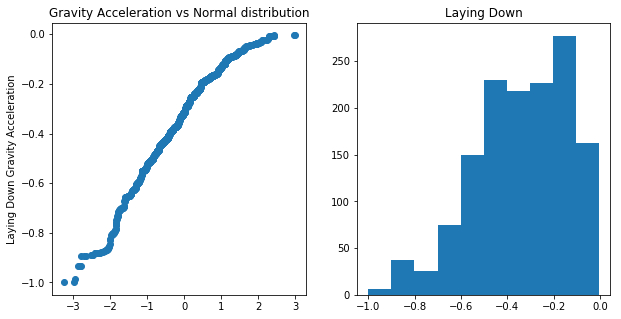

In [10]:
modeling_list = [laying_df]

#I am visualizing all the continuous data points with a QQ polt and a histogram
for each in modeling_list:
    #Set up the figure size
    f, ax = plt.subplots(figsize=(10, 5))
    plt.subplot(1, 2, 1)
            
    #Sort the values from the dataset
    result = each['tGravityAcc-min()-X'].sort_values()
    #Create a normal distribution variable
    norm = np.random.normal(0, 1, len(each))
    #Sort the values of the normal distribution
    norm.sort()
    #Create the QQ plot
    plt.plot(norm, result, "o")
    plt.ylabel('Laying Down Gravity Acceleration')
    plt.title('Gravity Acceleration vs Normal distribution')
            
    #Create the histogram of the dataset
    plt.subplot(1, 2, 2)
    plt.hist(result)
    plt.title('Laying Down')

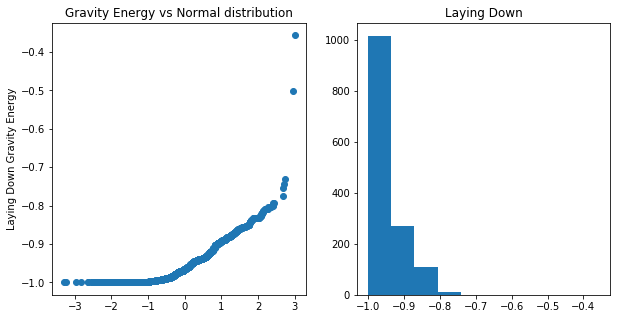

In [11]:
modeling_list = [laying_df]

#I am visualizing all the continuous data points with a QQ polt and a histogram
for each in modeling_list:
    #Set up the figure size
    f, ax = plt.subplots(figsize=(10, 5))
    plt.subplot(1, 2, 1)
            
    #Sort the values from the dataset
    result = each['tGravityAcc-energy()-X'].sort_values()
    #Create a normal distribution variable
    norm = np.random.normal(0, 1, len(each))
    #Sort the values of the normal distribution
    norm.sort()
    #Create the QQ plot
    plt.plot(norm, result, "o")
    plt.ylabel('Laying Down Gravity Energy')
    plt.title('Gravity Energy vs Normal distribution')
            
    #Create the histogram of the dataset
    plt.subplot(1, 2, 2)
    plt.hist(result)
    plt.title('Laying Down')

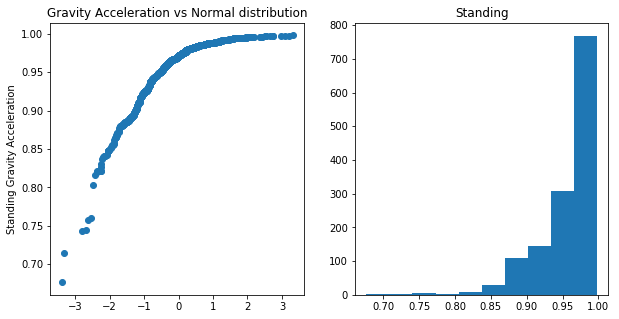

In [12]:
modeling_list = [standing_df]

#I am visualizing all the continuous data points with a QQ polt and a histogram
for each in modeling_list:
    #Set up the figure size
    f, ax = plt.subplots(figsize=(10, 5))
    plt.subplot(1, 2, 1)
            
    #Sort the values from the dataset
    result = each['tGravityAcc-min()-X'].sort_values()
    #Create a normal distribution variable
    norm = np.random.normal(0, 1, len(each))
    #Sort the values of the normal distribution
    norm.sort()
    #Create the QQ plot
    plt.plot(norm, result, "o")
    plt.ylabel('Standing Gravity Acceleration')
    plt.title('Gravity Acceleration vs Normal distribution')
            
    #Create the histogram of the dataset
    plt.subplot(1, 2, 2)
    plt.hist(result)
    plt.title('Standing')

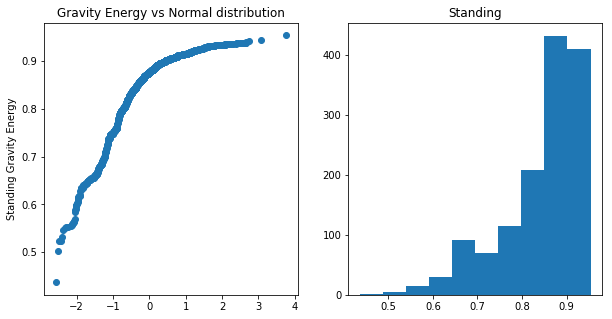

In [13]:
modeling_list = [standing_df]

#I am visualizing all the continuous data points with a QQ polt and a histogram
for each in modeling_list:
    #Set up the figure size
    f, ax = plt.subplots(figsize=(10, 5))
    plt.subplot(1, 2, 1)
            
    #Sort the values from the dataset
    result = each['tGravityAcc-energy()-X'].sort_values()
    #Create a normal distribution variable
    norm = np.random.normal(0, 1, len(each))
    #Sort the values of the normal distribution
    norm.sort()
    #Create the QQ plot
    plt.plot(norm, result, "o")
    plt.ylabel('Standing Gravity Energy')
    plt.title('Gravity Energy vs Normal distribution')
            
    #Create the histogram of the dataset
    plt.subplot(1, 2, 2)
    plt.hist(result)
    plt.title('Standing')

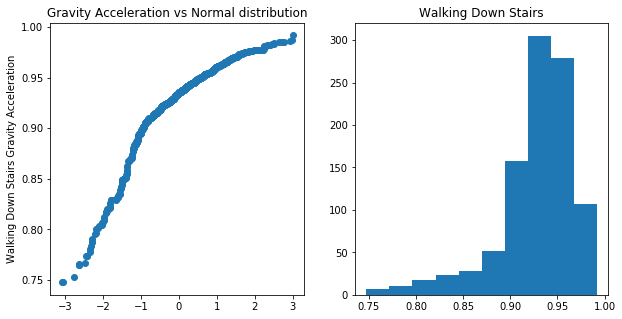

In [14]:
modeling_list = [walkDOWN_df]

#I am visualizing all the continuous data points with a QQ polt and a histogram
for each in modeling_list:
    #Set up the figure size
    f, ax = plt.subplots(figsize=(10, 5))
    plt.subplot(1, 2, 1)
            
    #Sort the values from the dataset
    result = each['tGravityAcc-min()-X'].sort_values()
    #Create a normal distribution variable
    norm = np.random.normal(0, 1, len(each))
    #Sort the values of the normal distribution
    norm.sort()
    #Create the QQ plot
    plt.plot(norm, result, "o")
    plt.ylabel('Walking Down Stairs Gravity Acceleration')
    plt.title('Gravity Acceleration vs Normal distribution')
            
    #Create the histogram of the dataset
    plt.subplot(1, 2, 2)
    plt.hist(result)
    plt.title('Walking Down Stairs')

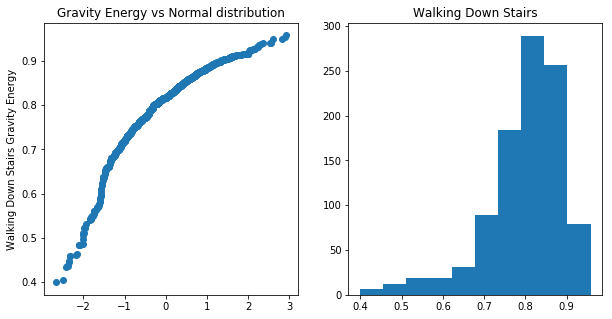

In [15]:
modeling_list = [walkDOWN_df]

#I am visualizing all the continuous data points with a QQ polt and a histogram
for each in modeling_list:
    #Set up the figure size
    f, ax = plt.subplots(figsize=(10, 5))
    plt.subplot(1, 2, 1)
            
    #Sort the values from the dataset
    result = each['tGravityAcc-energy()-X'].sort_values()
    #Create a normal distribution variable
    norm = np.random.normal(0, 1, len(each))
    #Sort the values of the normal distribution
    norm.sort()
    #Create the QQ plot
    plt.plot(norm, result, "o")
    plt.ylabel('Walking Down Stairs Gravity Energy')
    plt.title('Gravity Energy vs Normal distribution')
            
    #Create the histogram of the dataset
    plt.subplot(1, 2, 2)
    plt.hist(result)
    plt.title('Walking Down Stairs')

Before I move onto modeling my dataset, I want to check if the data is well balanced between the various activities and subject participants. 

In [16]:
for each in np.unique(train_data['Activity']):
    print(each)
    print("{}%".format(round((len(train_data[train_data['Activity']==each])/len(train_data))*100)))

LAYING
19%
SITTING
17%
STANDING
19%
WALKING
17%
WALKING_DOWNSTAIRS
13%
WALKING_UPSTAIRS
15%


In [17]:
for each in np.unique(train_data['subject']):
    print("subject {}".format(each))
    print("{}%".format(round((len(train_data[train_data['subject']==each])/len(train_data))*100)))

subject 1
5%
subject 3
5%
subject 5
4%
subject 6
4%
subject 7
4%
subject 8
4%
subject 11
4%
subject 14
4%
subject 15
4%
subject 16
5%
subject 17
5%
subject 19
5%
subject 21
6%
subject 22
4%
subject 23
5%
subject 25
6%
subject 26
5%
subject 27
5%
subject 28
5%
subject 29
5%
subject 30
5%


From this basic math I can see that the dataset is well balanced between both activites and participants. 

### Step Three

Model your outcome of interest. You should try several different approaches and really work to tune a variety of models before using the model evaluation techniques to choose what you consider to be the best performer. Make sure to think about explanatory versus predictive power and experiment with both.

In [19]:
# The outcomes of interest for both the train and test dataset
train_Y = train_data['Activity']
test_Y = test_data['Activity']

multiclass classification problem.  Read about the report: Sensitivity and Specificity. Be prepared to answer about why I didn't use a PCA. 

In [20]:
#Drop Subject and Acivity from features
train_data = train_data.drop(['subject', 'Activity'], axis=1)
test_data = test_data.drop(['subject', 'Activity'], axis=1)

## Random Forest Classifier

In [21]:
# Random Forest Classifier
rfc = ensemble.RandomForestClassifier()
rfc.fit(train_data,train_Y)
print("Report:")
y_true, y_pred = test_Y, rfc.predict(test_data)
print(classification_report(y_true, y_pred))
confusion_matrix(y_true, y_pred)

Report:
                    precision    recall  f1-score   support

            LAYING       0.99      1.00      1.00       537
           SITTING       0.88      0.87      0.88       491
          STANDING       0.89      0.89      0.89       532
           WALKING       0.81      0.97      0.88       496
WALKING_DOWNSTAIRS       0.94      0.86      0.90       420
  WALKING_UPSTAIRS       0.90      0.79      0.84       471

       avg / total       0.90      0.90      0.90      2947



array([[537,   0,   0,   0,   0,   0],
       [  3, 429,  59,   0,   0,   0],
       [  0,  60, 472,   0,   0,   0],
       [  0,   0,   0, 480,   6,  10],
       [  0,   0,   0,  27, 360,  33],
       [  0,   0,   0,  83,  15, 373]])

In [22]:
RFC_score = cross_val_score(rfc, test_data,test_Y, cv=5)
print('\nEach Cross Validated R2 score: \n', RFC_score)
print("\nOverall Random Forest Classifier R2: %0.2f (+/- %0.2f)\n" % (RFC_score.mean(), RFC_score.std() * 2))


Each Cross Validated R2 score: 
 [ 0.88701518  0.81864407  0.9047619   0.88605442  0.91666667]

Overall Random Forest Classifier R2: 0.88 (+/- 0.07)



In [45]:
# Saving the feature names
feature_list = list(test_data.columns)
# Get numerical feature importances
importances = list(rfc.feature_importances_)
# List of tuples with variable and importance
feature_importances = [(feature, round(importance, 2)) for feature, importance in zip(feature_list, importances)]
# Sort the feature importances by most important first
feature_importances = sorted(feature_importances, key = lambda x: x[1], reverse = True)
# Print out the feature and importances 
#[print('Variable: {:20} Importance: {}'.format(*pair)) for pair in feature_importances];

In [46]:
feature_importances = feature_importances[:20]
importance = []
importance_name = []
for each in feature_importances:
    importance.append(round(each[1], 2))
    importance_name.append(each[0])

In [47]:
feature_importances

[('tGravityAcc-min()-X', 0.040000000000000001),
 ('fBodyAcc-entropy()-X', 0.040000000000000001),
 ('fBodyAccJerk-mad()-X', 0.040000000000000001),
 ('fBodyAccJerk-entropy()-X', 0.040000000000000001),
 ('tGravityAcc-mean()-X', 0.029999999999999999),
 ('tGravityAcc-mean()-Y', 0.029999999999999999),
 ('tGravityAcc-min()-Y', 0.029999999999999999),
 ('tGravityAcc-energy()-X', 0.029999999999999999),
 ('fBodyAccJerk-bandsEnergy()-1,8', 0.029999999999999999),
 ('tGravityAcc-mean()-Z', 0.02),
 ('tGravityAcc-max()-Y', 0.02),
 ('tGravityAcc-max()-Z', 0.02),
 ('tGravityAcc-min()-Z', 0.02),
 ('tGravityAcc-arCoeff()-Y,2', 0.02),
 ('tGravityAcc-arCoeff()-Z,2', 0.02),
 ('tGravityAccMag-std()', 0.02),
 ('fBodyAccJerk-mean()-X', 0.02),
 ('fBodyAccJerk-energy()-X', 0.02),
 ('fBodyAccJerk-bandsEnergy()-1,24.1', 0.02),
 ('fBodyAccMag-mad()', 0.02)]

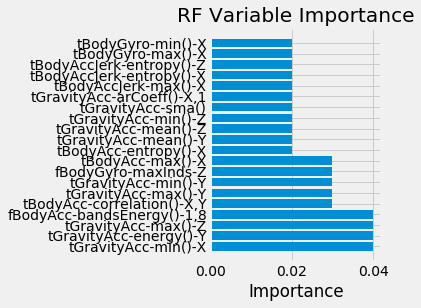

In [48]:
# take the top 20 most important features
sorted_idx = np.argsort(feature_importances)
pos = np.arange(sorted_idx.shape[0]) + .5
plt.subplot(1, 2, 2)
plt.barh(pos, importance, align='center')
plt.yticks(pos, importance_list)
plt.xlabel('Importance')
plt.title('RF Variable Importance')
plt.show()

## Gradient Boosting Classifier

In [39]:
# Initialize and fit the model.
clf = ensemble.GradientBoostingClassifier(loss = 'deviance')
clf.fit(train_data,train_Y)

GradientBoostingClassifier(criterion='friedman_mse', init=None,
              learning_rate=0.1, loss='deviance', max_depth=3,
              max_features=None, max_leaf_nodes=None,
              min_impurity_decrease=0.0, min_impurity_split=None,
              min_samples_leaf=1, min_samples_split=2,
              min_weight_fraction_leaf=0.0, n_estimators=100,
              presort='auto', random_state=None, subsample=1.0, verbose=0,
              warm_start=False)

In [40]:
print("Report:")
y_true, y_pred = test_Y, clf.predict(test_data)
print(classification_report(y_true, y_pred))
confusion_matrix(y_true, y_pred)

Report:
                    precision    recall  f1-score   support

            LAYING       1.00      1.00      1.00       537
           SITTING       0.93      0.85      0.89       491
          STANDING       0.88      0.94      0.91       532
           WALKING       0.94      0.98      0.96       496
WALKING_DOWNSTAIRS       0.98      0.92      0.95       420
  WALKING_UPSTAIRS       0.93      0.94      0.93       471

       avg / total       0.94      0.94      0.94      2947



array([[537,   0,   0,   0,   0,   0],
       [  0, 418,  70,   0,   0,   3],
       [  0,  32, 500,   0,   0,   0],
       [  0,   0,   0, 486,   4,   6],
       [  0,   0,   0,   7, 387,  26],
       [  0,   1,   0,  24,   5, 441]])

In [41]:
CLF_score = cross_val_score(clf, test_data, test_Y, cv=5)
print('\nEach Cross Validated R2 score: \n', CLF_score)
print("\nOverall Gradient Boosted Classifier R2: %0.2f (+/- %0.2f)\n" % (CLF_score.mean(), CLF_score.std() * 2))


Each Cross Validated R2 score: 
 [ 0.92411467  0.83898305  0.96428571  0.91326531  0.96938776]

Overall Gradient Boosted Classifier R2: 0.92 (+/- 0.09)



In [49]:
# Saving the feature names
feature_list = list(test_data.columns)
# Get numerical feature importances
importances = list(clf.feature_importances_)
# List of tuples with variable and importance
feature_importances = [(feature, round(importance, 2)) for feature, importance in zip(feature_list, importances)]
# Sort the feature importances by most important first
feature_importances = sorted(feature_importances, key = lambda x: x[1], reverse = True)
# Print out the feature and importances 
#[print('Variable: {:20} Importance: {}'.format(*pair)) for pair in feature_importances];

In [50]:
feature_importances = feature_importances[:20]
importance = []
importance_list = []
for each in feature_importances:
    importance.append(round(each[1], 2))
    importance_list.append(each[0])

In [56]:
feature_importances

[('tGravityAcc-min()-X', 0.10000000000000001),
 ('tGravityAcc-energy()-Y', 0.040000000000000001),
 ('tGravityAcc-max()-Z', 0.029999999999999999),
 ('fBodyAcc-bandsEnergy()-1,8', 0.029999999999999999),
 ('tBodyAcc-correlation()-X,Y', 0.02),
 ('tGravityAcc-max()-Y', 0.02),
 ('tGravityAcc-min()-Y', 0.02),
 ('fBodyGyro-maxInds-Z', 0.02),
 ('tBodyAcc-max()-X', 0.01),
 ('tBodyAcc-entropy()-X', 0.01),
 ('tGravityAcc-mean()-Y', 0.01),
 ('tGravityAcc-mean()-Z', 0.01),
 ('tGravityAcc-min()-Z', 0.01),
 ('tGravityAcc-sma()', 0.01),
 ('tGravityAcc-arCoeff()-X,1', 0.01),
 ('tBodyAccJerk-max()-X', 0.01),
 ('tBodyAccJerk-entropy()-X', 0.01),
 ('tBodyAccJerk-entropy()-Z', 0.01),
 ('tBodyGyro-max()-X', 0.01),
 ('tBodyGyro-min()-X', 0.01)]

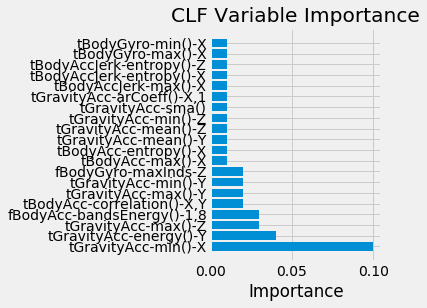

In [51]:
sorted_idx = np.argsort(feature_importances)
pos = np.arange(sorted_idx.shape[0]) + .5
plt.subplot(1, 2, 2)
plt.barh(pos, importance, align='center')
plt.yticks(pos, importance_list)
plt.xlabel('Importance')
plt.title('CLF Variable Importance')
plt.show()

## Support Vector Classifier

In [52]:
svc = SVC(kernel='linear')
svc.fit(train_data,train_Y)

SVC(C=1.0, cache_size=200, class_weight=None, coef0=0.0,
  decision_function_shape='ovr', degree=3, gamma='auto', kernel='linear',
  max_iter=-1, probability=False, random_state=None, shrinking=True,
  tol=0.001, verbose=False)

In [54]:
print("Report:")
y_true, y_pred = test_Y, svc.predict(test_data)
print(classification_report(y_true, y_pred))
confusion_matrix(y_true, y_pred)

Report:
                    precision    recall  f1-score   support

            LAYING       1.00      1.00      1.00       537
           SITTING       0.96      0.89      0.92       491
          STANDING       0.91      0.97      0.94       532
           WALKING       0.96      0.99      0.97       496
WALKING_DOWNSTAIRS       0.99      0.98      0.98       420
  WALKING_UPSTAIRS       0.98      0.96      0.97       471

       avg / total       0.96      0.96      0.96      2947



array([[537,   0,   0,   0,   0,   0],
       [  0, 435,  54,   0,   0,   2],
       [  0,  16, 516,   0,   0,   0],
       [  0,   0,   0, 492,   3,   1],
       [  0,   0,   0,   4, 410,   6],
       [  0,   0,   0,  18,   2, 451]])

In [55]:
SVC_score = cross_val_score(svc, test_data, test_Y, cv=5)
print('\nEach Cross Validated R2 score: \n', SVC_score)
print("\nOverall Support Vector Classifier R2: %0.2f (+/- %0.2f)\n" % (SVC_score.mean(), SVC_score.std() * 2))


Each Cross Validated R2 score: 
 [ 0.97133221  0.86779661  0.94387755  0.93367347  0.93367347]

Overall Support Vector Classifier R2: 0.93 (+/- 0.07)



# Conclusion

- Can the activity of a individual be accurately predicted from a smart phone's internal sensors?
- What variables are most important for a model to predict activity with a smart phone?
- Which model most accurately predicts activity with a smart phone?

This Capstone project provided a good but challenging opportunity to delve into a Human Activity Recognition dataset. I see this dataset and challenge as very applicable to many industries that are wanting to track human activity while also allowing for more sophisticated models to be created in the future. To return to my goals for this project, the Support Vector Classifier was able to achieve an R-squared values of 0.93 for predicting human activity from a smart phone's internal sensors.

The Support Vector Machine is very versatile and great as a classifier but it comes at the cost of explaining which features are most important in my dataset. So if my goal was to only create a model with very accurate predictions, I would choose the SVM because it was able to achieve the highest average accuracy of 0.96. If however I want a more explanatory model, the Gradient Boosting and Random Forest Classifiers are possible options. While both of these models are still less informative than a logistic regression model would be, they gave me overall accurate predictions and some information about which variables are most important for predicting the outcome. For instance, the three most commonly used features for both the Gradient Boosting and Random Forest models were about Gravity Acceleration. 
    
If I had more time on the project I would focus on optimizing my dataset because there are so many features. I would also want to create more explanatory models because this could help data scientist and engineers design better machines and models that focus on these important distinctions between activities.